In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
# from keras.models import Sequential
import matplotlib.pyplot as plt

%matplotlib inline
from torchbearer import Trial
import os

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.datasets import MNIST
from torchbearer import Trial
import torchvision.transforms as transforms

In [3]:
datapath = os.path.join(os.getcwd(), 'data')
datapath

'C:\\Users\\王隽文\\Desktop\\MSc-dissertation\\data'

In [4]:
df = pd.read_csv(os.path.join(datapath,'Integrated Data.csv'), engine='python')
df.tail()

,Date,Adj Close,Volume,2-days Net change,5day-moving average,5day- standard deviation,10-day moving average,10day- standard deviation,30-day moving average,30day- standard deviation,^VIX,^TNX
3016,2016/12/23,2263.790039,2020550000,2.830078,2264.643994,3.757096,2262.528003,5.773423,2185.648188,54.155056,11.44,2.543
3017,2016/12/27,2268.879883,1987080000,5.089844,2265.913965,3.932965,2263.719995,5.726416,2188.366187,54.863455,11.99,2.563
3018,2016/12/28,2249.919922,2392360000,-18.959961,2261.745947,7.199588,2261.539990,6.446745,2190.834585,54.799583,12.95,2.506
3019,2016/12/29,2249.260010,2336370000,-0.659912,2258.561963,8.671128,2261.137988,7.110240,2193.027783,54.901540,13.37,2.477
3020,2016/12/30,2238.830078,2670900000,-10.429932,2254.135986,12.107894,2258.817993,9.989011,2194.918584,54.816670,14.04,2.446


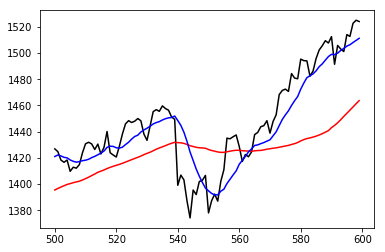

In [5]:
plt.plot(df['Adj Close'][500:600], color='k')
plt.plot(df['30-day moving average'][500:600],color='r')
plt.plot(df['10-day moving average'][500:600],color='b')

# build binary classifier

In [6]:
# 0 --> tomorrow goes down 
# 1 --> tomorrow goes up
# initialising
df['forecasting'] = 0

df['forecasting_10daysout'] = float('nan')
df['forecasting_20daysout'] = float('nan')
df['forecasting_30daysout'] = float('nan')
# if y > sp500: predict as go up
# else predict as go down
for i in df.index:
    try:
        if df['Adj Close'][i+1] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting'] = 1
        else:
            df.at[i, 'forecasting'] = 0
    except:
        print('rearch the end')
        
for i in df.index:
    try:
        if df['Adj Close'][i+10] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_10daysout'] = 1
        else:
            df.at[i, 'forecasting_10daysout'] = 0
    except:
        print('rearch the end')
for i in df.index:
    try:
        if df['Adj Close'][i+20] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_20daysout'] = 1
        else:
            df.at[i, 'forecasting_20daysout'] = 0
    except:
        print('rearch the end')
for i in df.index:
    try:
        if df['Adj Close'][i+30] > df['Adj Close'][i]:  # will go up?
            df.at[i, 'forecasting_30daysout'] = 1
        else:
            df.at[i, 'forecasting_30daysout'] = 0
    except:
        print('rearch the end')

        
df = df.dropna(axis=0)

rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end
rearch the end


In [7]:
df.forecasting_10daysout = df.forecasting_10daysout.astype(int)
df.forecasting_20daysout = df.forecasting_20daysout.astype(int)
df.forecasting_30daysout = df.forecasting_30daysout.astype(int)

df

,Date,Adj Close,Volume,2-days Net change,5day-moving average,5day- standard deviation,10-day moving average,10day- standard deviation,30-day moving average,30day- standard deviation,^VIX,^TNX,forecasting,forecasting_10daysout,forecasting_20daysout,forecasting_30daysout
29,2005/2/14,1206.140015,1290180000,0.839966,1200.548023,5.972420,1197.998010,6.471962,1186.938000,11.779314,11.520000,4.073,1,1,0,0
30,2005/2/15,1210.119995,1527080000,3.979980,1202.112012,7.399357,1200.069006,6.727023,1187.206002,12.218959,11.270000,4.098,1,0,0,0
31,2005/2/16,1210.339966,1490100000,0.219971,1205.782007,5.406050,1201.784009,6.960478,1187.948999,12.929107,11.100000,4.158,0,1,0,0
32,2005/2/17,1200.750000,1580120000,-9.589966,1206.530005,3.952125,1202.870007,5.615875,1188.515999,13.109877,11.770000,4.185,1,1,0,0
33,2005/2/18,1201.589966,1551200000,0.839966,1205.787988,4.544651,1202.726001,5.629762,1188.972664,13.324178,11.180000,4.260,0,1,0,0
34,2005/2/22,1184.160034,1744940000,-17.429932,1201.391992,10.649366,1200.970007,8.152000,1188.905001,13.343937,13.140000,4.285,1,1,0,0
35,2005/2/23,1190.800049,1501090000,6.640015,1197.528003,10.185715,1199.820007,8.733905,1188.923336,13.346226,12.390000,4.268,1,1,0,1
36,2005/2/24,1200.199951,1518750000,9.399902,1195.500000,7.704286,1200.641004,8.290723,1189.497001,13.451850,11.570000,4.281,1,1,0,0
37,2005/2/25,1211.369995,1523680000,11.170044,1197.623999,10.478090,1202.077002,8.818736,1190.286003,14.024779,11.490000,4.272,0,0,0,0
38,2005/2/28,1203.599976,1795480000,-7.770019,1198.026001,10.704402,1201.906995,8.765928,1191.157670,14.012115,12.080000,4.359,1,1,0,0


Now instead of set the next day's value as target,
we will set the forecasting as target

In [8]:
print(len(df))
X = df.values[:,1:-4]
y = df.values[:,-1] # 30_days ahead forecasting
print(X.shape, y.shape)

2958
(2958, 11) (2958,)


In [9]:
X

array([[1206.140015, 1290180000, 0.839966, ..., 11.77931359, 11.52,
        4.073],
       [1210.119995, 1527080000, 3.9799800000000003, ..., 12.21895918,
        11.27, 4.098],
       [1210.339966, 1490100000, 0.219971, ..., 12.92910707, 11.1, 4.158],
       ...,
       [2164.199951, 5367200000, -0.25, ..., 22.14454909, 14.48, 2.222],
       [2180.389893, 4543860000, 16.189942000000002, ..., 21.93060761,
        13.37, 2.238],
       [2176.939941, 3830590000, -3.4499519999999997, ..., 21.61776338,
        13.72, 2.2230000000000003]], dtype=object)

# testing train_test_split.py

In [10]:
from train_test_split import utility_fun

# decide to use which model
flag = 'mlp'

In [11]:
temp = utility_fun([X, y], len_of_trainset = 2000, time_interval = 50, batch_size=1)

temp.norm('classifier')
temp.sepera_time_step()
temp.test_train_split()
trainloader, testloader, validateData, target, trainData, testData = temp.build_dataloader(flag)
print(validateData.shape, trainData.shape, testData.shape)

classifier
torch.Size([909, 1, 50, 11]) torch.Size([2000, 1, 50, 11]) torch.Size([2000, 1])


In [12]:
trainData.shape
a = trainData.view(2000, -1, 11)

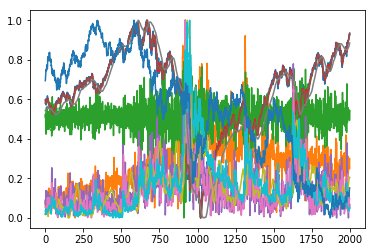

In [13]:
b = a[:,0,:]

for i in range(11):
    plt.plot(b[:,i].numpy())

# create model and training

In [14]:
from torchsummary import summary

In [15]:
# define baseline MLP model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)        
        out = self.fc2(out)
        out = F.sigmoid(out)
        return out
    
# model = BaselineModel(50*11, 220, 1)
# summary(model, (1,550))

In [16]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (15, 11), padding=0)
        self.conv2 = nn.Conv2d(64, 32, kernel_size = (15, 1), padding=0)
        self.fc1 = nn.Linear(512 , 1)
        
        
    def forward(self,x):
        out = self.conv1(x)
        out = F.max_pool2d(out, kernel_size = (4, 1), stride=(1, 1))
        out = F.dropout(out, 0.2)
        out = self.conv2(out)
        out = F.max_pool2d(out, kernel_size = (4, 1), stride=(1, 1))
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.sigmoid(out)
        return out

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)


# summary(your_model, input_size=(channels, H, W))
summary(model,(1, 50, 11))
print(model)

E:\anacoda\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 64, 36, 1]          10,624
            Conv2d-2            [-1, 32, 19, 1]          30,752
            Linear-3                    [-1, 1]             513
Total params: 41,889
Trainable params: 41,889
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.16
Estimated Total Size (MB): 0.18
----------------------------------------------------------------
Net(
  (conv1): Conv2d(1, 64, kernel_size=(15, 11), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(15, 1), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=1, bias=True)
)


In [17]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=1):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, dropout = 0.2)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, x):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
#         print(x.shape)
        lstm_out, self.hidden = self.lstm(x.view(1, self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        out = F.sigmoid(y_pred.view(-1))
#         print(out)
        return out

    
lstm_input_size = 550
num_train = 1
output_dim = 1
num_layers = 1
h1 = 500

device = 'cpu'
model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers).to(device)

print(model)

E:\anacoda\lib\site-packages\torch\nn\modules\rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(550, 500, dropout=0.2)
  (linear): Linear(in_features=500, out_features=1, bias=True)
)


# Training

In [18]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, flag)


if flag == 'mlp':
    model = BaselineModel(50*11, 220, 1)
if flag == '1dconv':
    model = Net()
if flag == 'lstm':
    model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers).to(device)
    
    
# define the loss function and the optimiser
# loss_function = nn.MSELoss()

#classification problem  we use bce loss
loss_function = nn.BCELoss()
optimiser = optim.Adam(model.parameters())

trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
# trial.with_generators(trainloader, test_generator=validateData.view(len(validateData), -1))
trial.with_generators(trainloader, test_generator=testloader)
trial.run(epochs=3)
# results = trial.evaluate(data_key=torchbearer.TEST_DATA)

cuda:0 mlp


E:\anacoda\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[{'running_loss': 0.666968822479248,
  'running_binary_acc': 0.6200000047683716,
  'loss': 0.6647732853889465,
  'binary_acc': 0.6220000386238098,
  'train_steps': 2000,
  'validation_steps': None},
 {'running_loss': 0.604500949382782,
  'running_binary_acc': 0.6800000071525574,
  'loss': 0.621191143989563,
  'binary_acc': 0.6585000157356262,
  'train_steps': 2000,
  'validation_steps': None},
 {'running_loss': 0.5909529328346252,
  'running_binary_acc': 0.6599999666213989,
  'loss': 0.5810814499855042,
  'binary_acc': 0.6910000443458557,
  'train_steps': 2000,
  'validation_steps': None}]

## testing

In [ ]:
result = trial.predict()

your_file = open(flag+'_result.csv', 'ab')
np.savetxt(your_file, result.cpu().numpy())
your_file.close()

# stacking method

In [ ]:
results = []
for i in ['mlp_result', '1dconv_result', 'lstm_result']:
    results.append(pd.read_csv(i+'.csv').to_numpy())

In [ ]:
final_result = (results[0] + results[1]+ results[2])/3
final_result.shape

# evaluation

E:\anacoda\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


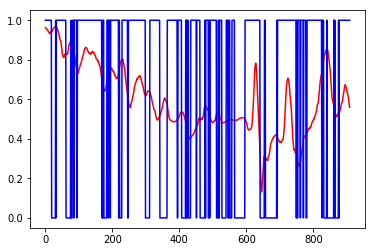

In [19]:
y_pred= model(validateData.view(909,-1).cuda().float())
y_pred.shape

plt.plot(y_pred.cpu().detach().numpy(), 'r-')
plt.plot(target.cpu().numpy(), 'b-')
plt.show()

In [23]:
a = []
for i in y_pred:
    if i >= 0.5:
        a.append(1)
    else:
        a.append(0)

from pycm import ConfusionMatrix

y_actu = target.numpy().astype(int)
y_pred = a
cm = ConfusionMatrix(y_actu, y_pred)
print(cm)

Predict   0         1         
Actual
0         107       187       

1         200       415       





Overall Statistics : 

95% CI                                                            (0.54211,0.6064)
ACC Macro                                                         0.57426
AUNP                                                              0.51937
AUNU                                                              0.51937
Bennett S                                                         0.14851
CBA                                                               0.51167
Chi-Squared                                                       1.33482
Chi-Squared DF                                                    1
Conditional Entropy                                               0.92158
Cramer V                                                          0.03832
Cross Entropy                                                     0.90874
F1 Macro                                              

In [25]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_actu
y_probas = y_pred

fpr, tpr, thresholds = skplt.metrics.roc_curve(y_true, y_probas)
# plt.show()

Text(0,0.5,'tpr')

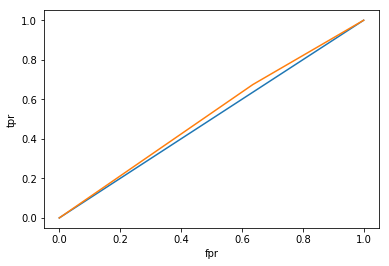

In [26]:
X = [0, 1]
y = [0, 1]
plt.plot(X,y)
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')

In [ ]:
plt.hist(thresholds, fpr)
plt.hist(thresholds, tpr)
plt.show()

# generate gradient

In [ ]:
class gradient_generator():
    
    def __init__(self, model):
        
        self.loss = nn.BCELoss()
        self.model = model.to('cpu')
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook = self.hook_layers()
    def hook_layers(self):    
        def hook_function(module, grad_in, grad_out):
#             print("hook called")
            self.gradients = grad_out[0]
#         print(list(self.model._modules.items()))
        first_layer = list(self.model._modules.items())[0][1]
        hook = first_layer.register_backward_hook(hook_function)
        return hook
    def generate_gradient(self, inputs, labels):
        self.model.zero_grad()
        output = self.model(inputs)
        loss = self.loss(output, labels)
        output.backward()
        
        self.hook.remove()
        return self.gradients
    

grad = torch.zeros((2000,220))
i = 0

for data in range(len(trainData)):
    inputs = trainData[data,:,:,:].view(1,-1)
    labs = testData[data,:].view(-1).float()
#     print(inputs.shape, labels.shape)
    GG = gradient_generator(model)
    temp = GG.generate_gradient(ins, labs)
    grad[i,:] = temp
    i += 1

In [ ]:
grad.shape

In [ ]:
grad

# Visualisation

In [ ]:
plt.plot(df['forecasting_30daysout'])

In [ ]:
df.head()

In [ ]:
# from sklearn import preprocessing

# df_norm = df.drop(columns=['Date','forecasting','forecasting_10daysout','forecasting_20daysout','forecasting_30daysout'],axis=0)
# x = df_norm.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_norm = pd.DataFrame(x_scaled)


In [ ]:
# df_norm[0:20]

In [ ]:
plt.imshow(df_norm[0:30], cmap=plt.get_cmap('gray'))

In [ ]:
a = trainData.view(len(trainData),-1).float()
image = a[500:700, :]
grad_img = grad.data[500:700,:]

plt.imshow(grad_img * image, cmap=plt.get_cmap('gray'))

In [ ]:
plt.imshow(image, cmap=plt.get_cmap('gray'))

In [ ]:
plt.imshow(grad_img, cmap=plt.get_cmap('gray'))

# sliding windows

In [ ]:
from train_test_split import utility_fun

#classification problem  we use bce loss
loss_function = nn.BCELoss()
optimiser = optim.Adam(model.parameters())
device = "cuda:0" if torch.cuda.is_available() else "cpu"
cor = 0
mis = 0
for i in range(2000, 2500):
    temp = utility_fun([X, y], len_of_trainset = i, time_interval = 50)

    temp.norm()
    temp.sepera_time_step()
    temp.test_train_split()
    trainloader, validateData,_ ,_ = temp.build_dataloader()

    model = BaselineModel(550, 500, 1)
     
    trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], verbose = False).to(device)
    trial.with_generators(trainloader)
    trial.run(epochs=2)
    
    y_pred= model(validateData.view(validateData.shape[0],-1)[0].to(device).float())
    if y_pred.data > 0.5:
        a = 1
    else:
        a = 0
    if a == y[i]:
        cor += 1
    else:
        mis += 1
        
    print("the {}th day, pred: {} ---- true: {} ====== correct: {} ---- miscorrect: {}".format(i, a, y[i],cor,mis))